<a href="https://colab.research.google.com/github/aakashpix/E-Commerce-Transactions-Analysis/blob/main/Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

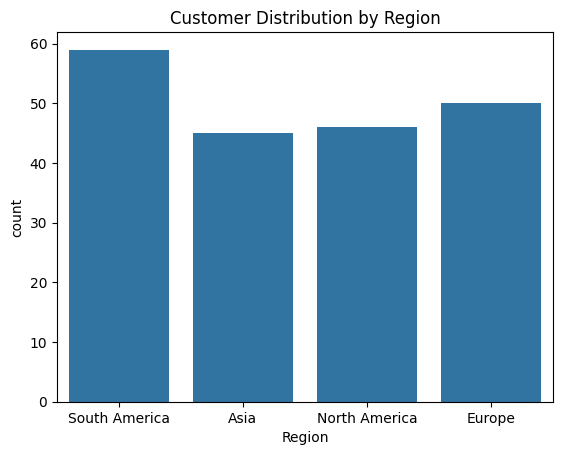

<ipython-input-1-e2495f14b6d5>:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  transactions.resample('M').sum()['TotalValue'].plot()


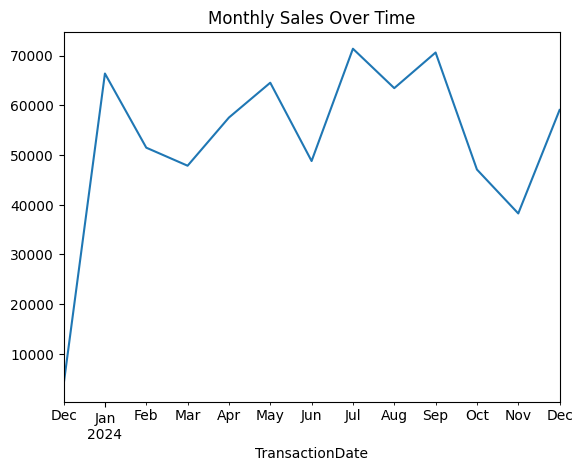

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

print(customers.head())
print(products.head())
print(transactions.head())

print(customers.describe())
print(products.describe())
print(transactions.describe())

print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

print(customers.duplicated().sum())
print(products.duplicated().sum())
print(transactions.duplicated().sum())

sns.countplot(data=customers, x='Region')
plt.title('Customer Distribution by Region')
plt.show()

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions.set_index('TransactionDate', inplace=True)
transactions.resample('M').sum()['TotalValue'].plot()
plt.title('Monthly Sales Over Time')
plt.show()

In [2]:
customer_transactions = transactions.merge(customers, on='CustomerID')
customer_features = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Region': 'first',
    'SignupDate': 'first'
}).reset_index()


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features[['TotalValue', 'Quantity']])

similarity_matrix = cosine_similarity(features_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])

lookalike_dict = {}

for customer in customer_features['CustomerID']:
    similar_customers = similarity_df[customer].nlargest(4).index[1:]
    scores = similarity_df[customer].nlargest(4).values[1:]
    lookalike_dict[customer] = list(zip(similar_customers, scores))

lookalike_data = []

for customer_id, lookalikes in lookalike_dict.items():
    for lookalike, score in lookalikes:
        lookalike_data.append({'CustomerID': customer_id, 'LookalikeID': lookalike, 'Score': score})

lookalike_df = pd.DataFrame(lookalike_data)

lookalike_df.to_csv('Aakash_Lookalike.csv', index=False)

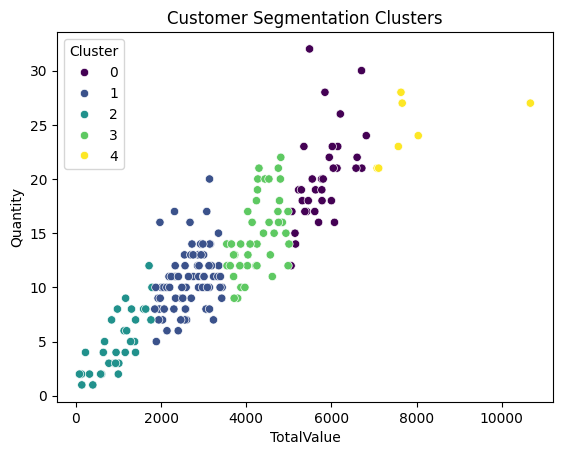

In [3]:
cluster_data = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Region': 'first'
}).reset_index()

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_data['Cluster'] = kmeans.fit_predict(cluster_data[['TotalValue', 'Quantity']])

db_index = davies_bouldin_score(cluster_data[['TotalValue', 'Quantity']], cluster_data['Cluster'])

sns.scatterplot(data=cluster_data, x='TotalValue', y='Quantity', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation Clusters')
plt.show()